In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

import gmaps
import gmaps.geojson_geometries

from Project_Gas_Library import f_EIA_ListSeries, f_EIA_ExtractData, f_PlotData, f_EIA_PlotData, f_EIA_PlotData_Mod,\
f_WorldWeather_ExtractData, f_PlotData, f_Census_ExtractData, calculate_color, f_strToDate, f_EIA_ExtractData_Range, \
f_EIA_PlotData_Range, f_EIA_PlotData_Mod_Range, f_EIA_PlotData_Stack_Range, adf, RMSE, calculate_color_1

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA

#from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


from datetime import datetime
from dateutil.relativedelta import relativedelta
from calendar import monthrange

from config import worldweather_key, g_key, EIA_key, census_key

from matplotlib.pyplot import cm
from citipy import citipy
from pprint import pprint

from matplotlib.cm import viridis
from matplotlib.colors import to_hex

from census import Census

In [2]:
ProdYear = 2011

In [3]:
file = "county_production.csv"
df = pd.read_csv(file)
df = df[["State","County_Name","Year","Mscf"]]
df["County_Name"]=df['County_Name'].str.replace(' County','',regex=True)
df_county_year=df.loc[df["Year"]==ProdYear,["State","County_Name","Mscf"]]

In [4]:
gmaps.configure(api_key=g_key)
gmap_geo_us_counties = gmaps.geojson_geometries.load_geometry('us-counties')

fig = gmaps.figure()

gmap_geo_layer = gmaps.geojson_layer(gmap_geo_us_counties)
fig.add_layer(gmap_geo_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [5]:
vx = list(df_county_year["County_Name"])
vy  = list(df_county_year["Mscf"])
dict_par = dict(zip(vx,vy))

min_par = np.power(min(list(df["Mscf"])),0.10)
max_par = np.power(max(list(df["Mscf"])),0.10)

#min_par = min(vy)
#max_par = max(vy)

colors = []
for feature in gmap_geo_us_counties['features']:
    county_name = feature['properties']['NAME']
    try:
        par = np.power(dict_par[county_name],0.10)
        #par = dict_par[county_name]
        color = calculate_color_1(par,min_par,max_par)
    except KeyError:
        # no value for that county: return default color
        color = (0, 0, 0, 0.3)
    colors.append(color)

fig = gmaps.figure()
poverty_layer = gmaps.geojson_layer(gmap_geo_us_counties,fill_color=colors,stroke_color=colors,fill_opacity=0.8)
#gini_layer = gmaps.geojson_layer(x,fill_color=colors,stroke_color=colors)
fig.add_layer(poverty_layer)
fig

Figure(layout=FigureLayout(height='420px'))

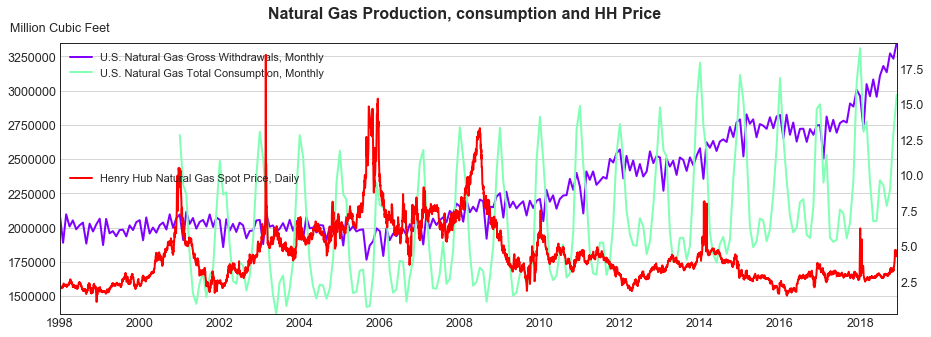

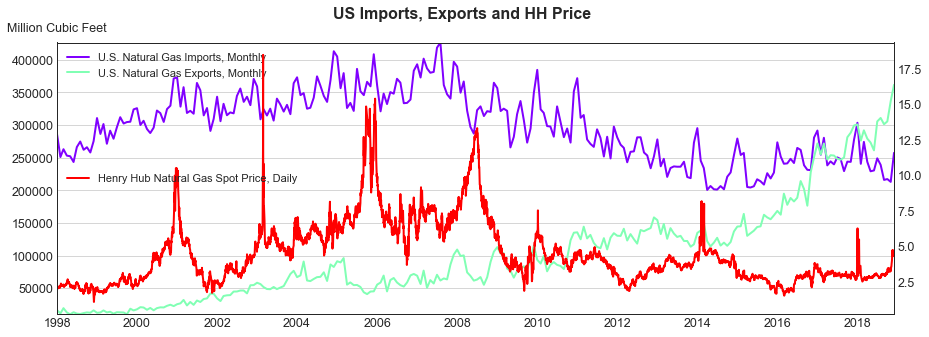

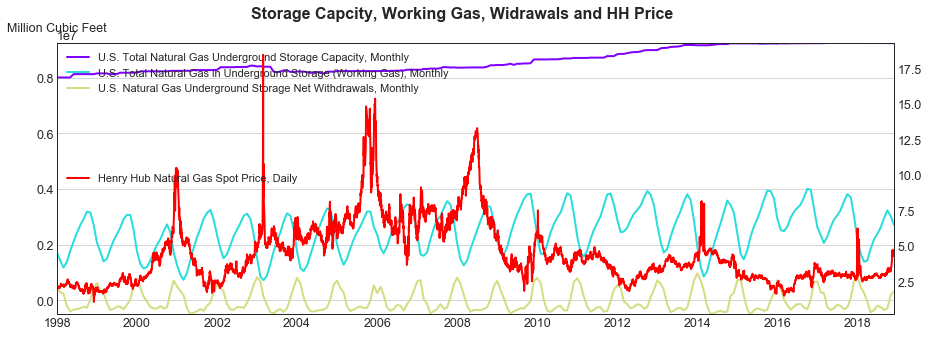

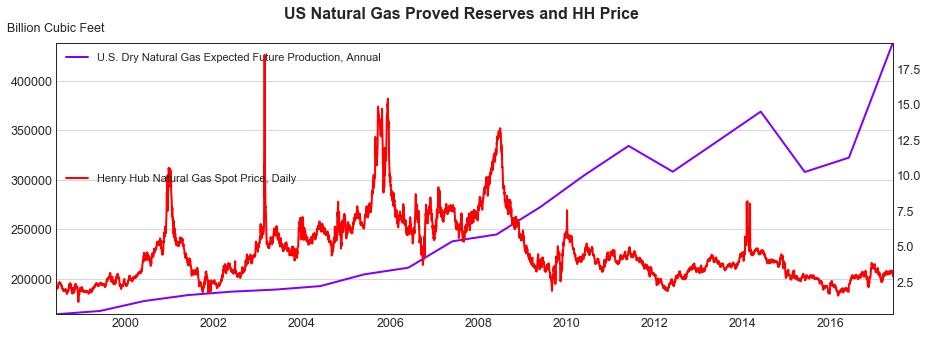

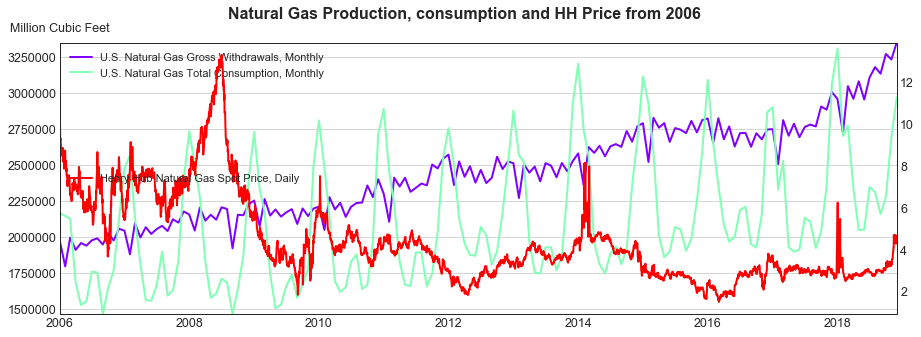

In [6]:
#Defining variables to extract data from EIA
eia_api_key = EIA_key
url = "http://api.eia.gov/series/"

Price_series_id =["NG.RNGWHHD.D"] # HH Prices
Volume_series_id = ["NG.N9010US2.M","NG.N9140US2.M"] # Total Widrawals Consumption

ImpEx_series_id = [ "NG.N9100US2.M", "NG.N9130US2.M"] # Import and Exports

Storage_series_id = ["NG.N5290US2.M","NG.N5020US2.M","NG.N5070US2.M"]
#Capacity, working gas, witdrawals

Reserves_series_id = ["NG.RNGR11NUS_1.A"]

ini_date = "1998-1-1"
end_date = "2018-12-31"

#Extracting and Ploting data from EIA
title = "Natural Gas Production, consumption and HH Price"
f_EIA_PlotData_Mod_Range(Volume_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "US Imports, Exports and HH Price"
f_EIA_PlotData_Mod_Range(ImpEx_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "Storage Capcity, Working Gas, Widrawals and HH Price"
f_EIA_PlotData_Mod_Range(Storage_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "US Natural Gas Proved Reserves and HH Price"
f_EIA_PlotData_Mod_Range(Reserves_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

ini_date = "2006-1-1"
end_date = "2018-12-31"

#Extracting and Ploting data from EIA
title = "Natural Gas Production, consumption and HH Price from 2006"
f_EIA_PlotData_Mod_Range(Volume_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

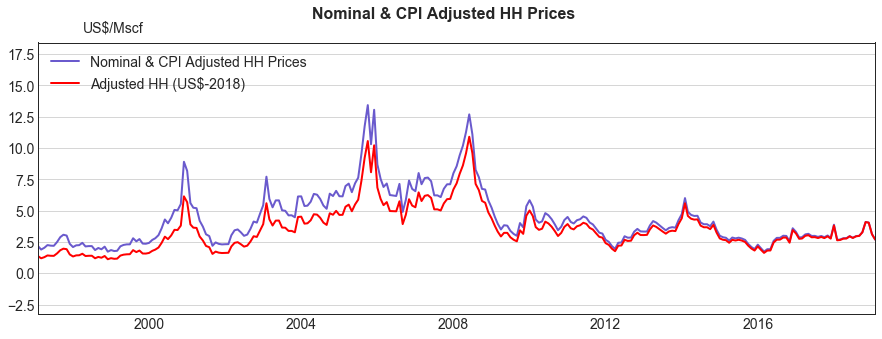

In [7]:
series_id_price = "NG.RNGWHHD.D" #HH

lx_hh_d, ly_hh_d, title_hh_d, country_hh_d, unit_hh_d = f_EIA_ExtractData(url,eia_api_key,series_id_price)
#convert output to a dictionary
d_hh = {
    "Date": lx_hh_d,
    "HH Price":ly_hh_d
}

#convert the dictionary to a dataframe 
df_hh = pd.DataFrame(d_hh)
# making the date column a panda date variable
df_hh["Date"]= pd.to_datetime(df_hh['Date'])

#convert the daily data to monthly data (Aggregation helps to reduce volatility !!!!!!!!)
df_hh = df_hh.set_index('Date')
df_hh_m = df_hh.resample('MS').mean()
df_hh_m.reset_index(inplace=True)

# converting panda date type to object
for index, row in df_hh_m.iterrows():
    str_date = str(row["Date"].year) + "-" + str(row["Date"].month) + "-" + str(row["Date"].day)
    df_hh_m.loc[index,"Date_1"] = datetime.strptime(str_date,'%Y-%m-%d').date()
del df_hh_m['Date']
df_hh_m = df_hh_m.rename(columns={'Date_1': 'Date'})

#Obtaining the CPI values
file = "CPIAUCSL.csv"
df_cpi = pd.read_csv(file)
# making the date column a panda date variable
df_cpi["DATE"]= pd.to_datetime(df_cpi['DATE'])

df_cpi = df_cpi.rename(columns={'DATE': 'Date',"CPIAUCSL" :"CPI"})

# converting panda date type to object
for index, row in df_cpi.iterrows():
    str_date = str(row["Date"].year) + "-" + str(row["Date"].month) + "-" + str(row["Date"].day)
    df_cpi.loc[index,"Date_1"] = datetime.strptime(str_date,'%Y-%m-%d').date()
del df_cpi['Date']
df_cpi = df_cpi.rename(columns={'Date_1': 'Date'})

#Creating a dataframe that storage info related to HH
df_HH = df_hh_m.merge(df_cpi,on="Date",how="inner")

# Correcting HH prices by inflation using CPI - the objective is to convert prices to US$ 2018
maxDate = df_HH["Date"].max()
updCPI = df_HH.loc[df_HH["Date"]==maxDate,"CPI"]
updCPI=min(updCPI)
df_HH["CPI-2018"] = df_HH["CPI"]*1/updCPI
df_HH["HH Price Upd"] = df_HH["HH Price"]*df_HH["CPI-2018"]

#Creating the log Prices columns
df_HH["Log HH Price"] = np.log(df_HH["HH Price"])
df_HH["Log HH Price Upd"] = np.log(df_HH["HH Price Upd"])

#Creating Columns with shift
df_HH["Log HH Price Upd Shift 1"] = df_HH["Log HH Price Upd"].shift()
df_HH["Log HH Price Shift 1"] = df_HH["Log HH Price"].shift()
df_HH=df_HH.dropna()

#Ploting HH and adjusted HH Prices
title = "Nominal & CPI Adjusted HH Prices"
unit = "US$/Mscf"
fig, ax = f_PlotData(df_HH["Date"],df_HH["HH Price"], title, unit)
ax.plot(df_HH["Date"],df_HH["HH Price Upd"], linewidth=2,color="red",label="Adjusted HH (US$-2018)")
ax.legend(loc='upper left')
plt.savefig(FileName)
FileName = "Figures-Presentation/" + title + ".png"
plt.show()

In [8]:
ini_date = "2006-1-1"; end_date = "2018-12-31"

series_id = Volume_series_id[0]
x_prod, y_prod, title_prod, country_prod, unit_prod = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = ImpEx_series_id[0]
x_imp, y_imp, title_imp, country_imp, unit_imp = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = ImpEx_series_id[1]
x_exp, y_exp, title_exp, country_exp, unit_exp = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

#Capacity, working gas, witdrawals

series_id = Storage_series_id[0] #Capacity
x_stocap, y_stocap, title_stocap, country_stocap, unit_stocap = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

#series_id = Storage_series_id[1]
#x_sto, y_sto, title_sto, country_sto, unit_sto = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Storage_series_id[1] # Working Gas
x_wg, y_wg, title_sto, country_sto, unit_sto = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Storage_series_id[2] # Widrawals
x_wit, y_wit, title_wit, country_wit, unit_wit = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Volume_series_id[1]
x_com, y_com, title_com, country_com, unit_com = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

y_price = []
for i in range(0,len(x_prod),1):
        HH_Price_Upd = min(df_HH.loc[df_HH["Date"]==x_prod[i],"HH Price Upd"])
        y_price.append(HH_Price_Upd)

dict_data = {
    "Price 2018 US$": y_price,
    "Production": y_prod,
    "Comsumption": y_com,
    "Storage Capacity": y_stocap,
    "Import": y_imp,
    "Export": y_exp
    #"Widrawals": y_wit,
    #"Working Gas": y_wg
}

df_data = pd.DataFrame(dict_data)

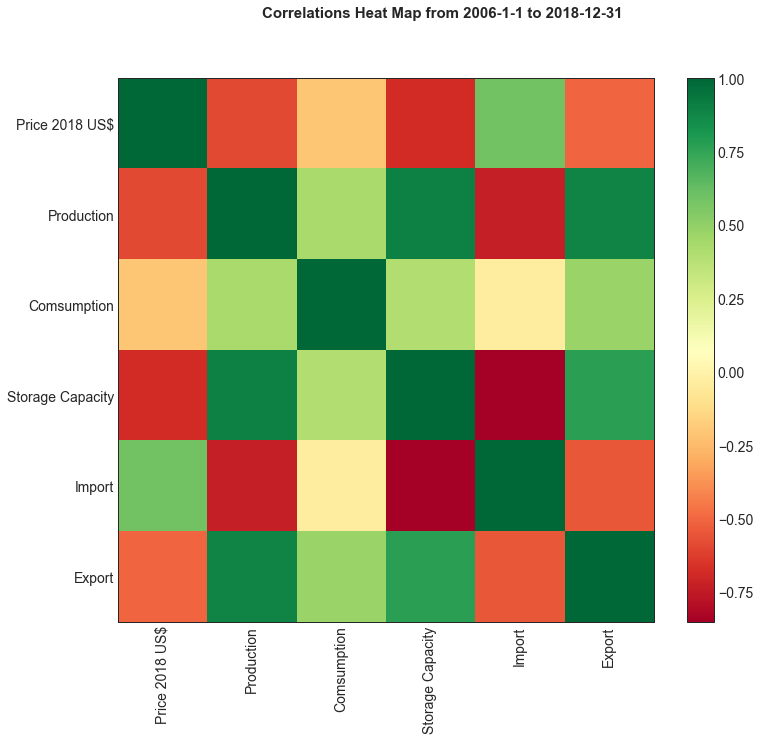

In [9]:
#Compute Correlation
corr = df_data.corr()

#Plot Correlation Matrix using Matplotlib
#%pylab inline
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
str_Title = 'Correlations Heat Map from ' + ini_date + ' to ' + end_date
plt.suptitle(str_Title, fontsize=15, fontweight='bold')
FileName ="Figures-Presentation/" + str_Title + ".png"
plt.savefig(FileName)
plt.show()

In [11]:
corr

,Price 2018 US$,Production,Comsumption,Storage Capacity,Import,Export
Price 2018 US$,1.000000,-0.590043,-0.201468,-0.678422,0.588801,-0.499535
Production,-0.590043,1.000000,0.430716,0.901113,-0.734172,0.887897
Comsumption,-0.201468,0.430716,1.000000,0.401218,-0.039993,0.476728
Storage Capacity,-0.678422,0.901113,0.401218,1.000000,-0.851682,0.770428
Import,0.588801,-0.734172,-0.039993,-0.851682,1.000000,-0.542445
Export,-0.499535,0.887897,0.476728,0.770428,-0.542445,1.000000


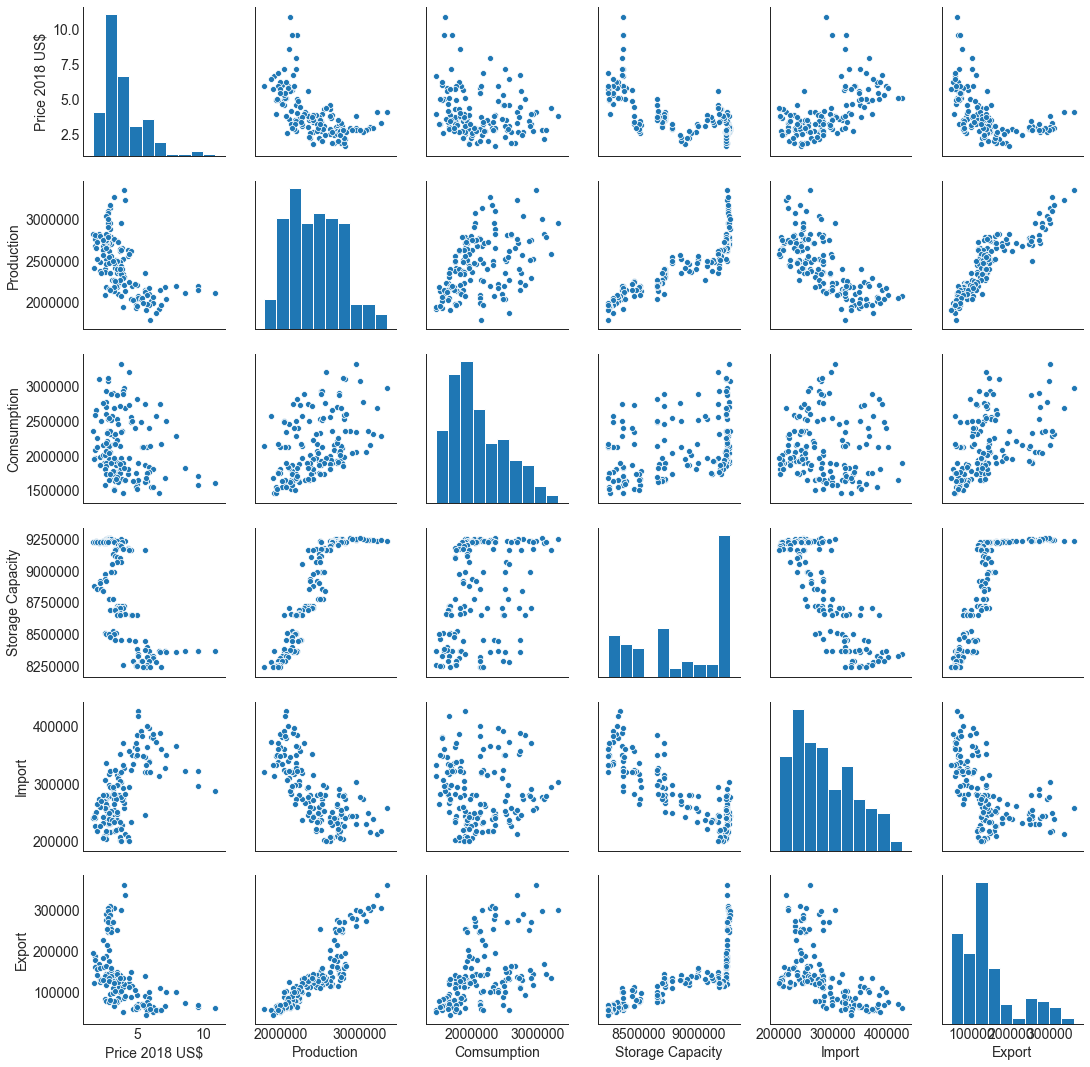

In [10]:
sns.pairplot(df_data)
str_Title = "Pairplot"
FileName ="Figures-Presentation/" + str_Title + ".png"
plt.savefig(FileName)
plt.show()

In [12]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Production","Comsumption","Storage Capacity","Import","Export"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
model.summary()

Production         -2.593372e-08
Comsumption        -3.093768e-07
Storage Capacity    9.726004e-08
Import              1.516026e-05
Export             -4.113976e-06
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Price 2018 US$   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     311.0
Date:                Fri, 29 Mar 2019   Prob (F-statistic):           1.38e-77
Time:                        16:52:26   Log-Likelihood:                -255.36
No. Observations:                 156   AIC:                             520.7
Df Residuals:                     151   BIC:                             536.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Production       -2.593e-08   9.91e-07     -0.026      0.979   -1.98e-06    1.93e-06
Comsumption      -3.094e-07   2.92e-07     -1.060      0.291   -8.86e-07    2.67e-07
Storage Capacity  9.726e-08   2.77e-07      0.350      0.726   -4.51e-07    6.46e-07
Import            1.516e-05   2.31e-06      6.549      0.000    1.06e-05    1.97e-05
Export           -4.114e-06   3.15e-06     -1.304      0.194   -1.03e-05    2.12e-06
==============================================================================
Omnibus:                       82.124   Durbin-Watson:                   0.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.919
Skew:                           1.951   Prob(JB):                     7.08e-84
Kurtosis:                       9.609   Cond. No.                         304.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

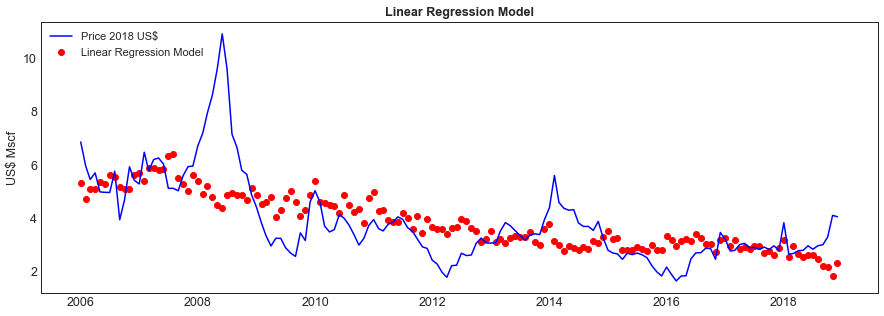

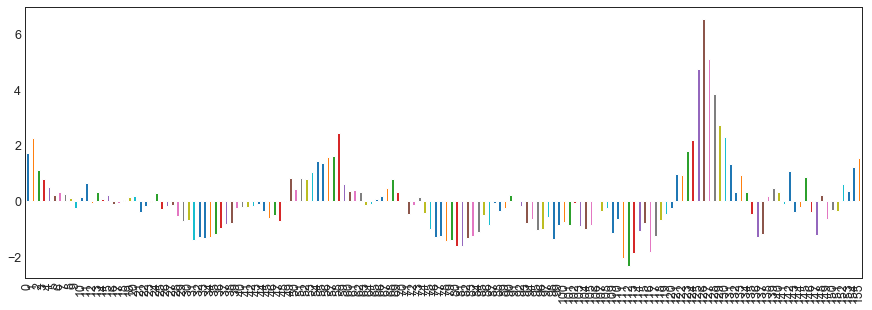

In [13]:
model_pred = model.predict()
x_prod

large = 16; med = 12.5; small = 11
params = {'axes.titlesize': med,
        'legend.fontsize': small,
        'figure.figsize': (15, 5),
        'axes.labelsize': med,
        'axes.titlesize': med,
        'xtick.labelsize': med,
        'ytick.labelsize': med,
        'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

plt.scatter(x_prod,model_pred,c="r",label="Linear Regression Model")
plt.plot(x_prod,df_data["Price 2018 US$"],c="b",label="Price 2018 US$")
plt.ylabel("US$ Mscf")
plt.legend(loc="upper left")

str_title = "Linear Regression Model"
plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.savefig(FileName)

plt.show()


model.resid.plot(kind="bar")


In [14]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Production"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
print(f"R2: {R2}")
print(f"p: {pp}")

Production    0.000001
dtype: float64
R2: 0.784104839351856
p: Production    1.827905e-53
dtype: float64


In [15]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Comsumption"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
print(f"R2: {R2}")
print(f"p: {pp}")

Comsumption    0.000002
dtype: float64
R2: 0.7934975489967575
p: Comsumption    5.784793e-55
dtype: float64


In [16]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Storage Capacity"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
print(f"R2: {R2}")
print(f"p: {pp}")

Storage Capacity    4.304679e-07
dtype: float64
R2: 0.8323862028739588
p: Storage Capacity    5.362444e-62
dtype: float64


In [17]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Import"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
print(f"R2: {R2}")
print(f"p: {pp}")

Import    0.000014
dtype: float64
R2: 0.902505796856233
p: Import    2.977878e-80
dtype: float64


In [18]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Export"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
print(f"R2: {R2}")
print(f"p: {pp}")

Export    0.000019
dtype: float64
R2: 0.5386271248514496
p: Export    7.982257e-28
dtype: float64


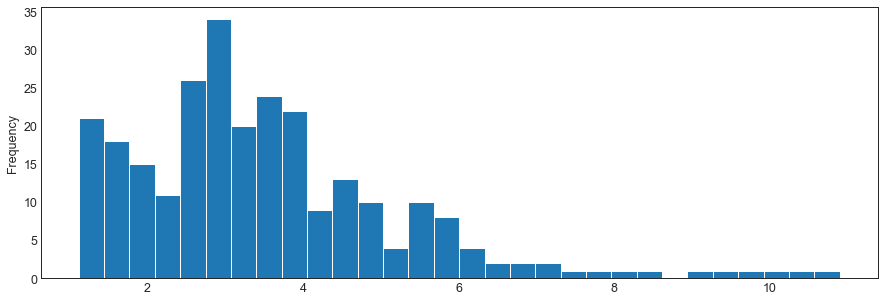

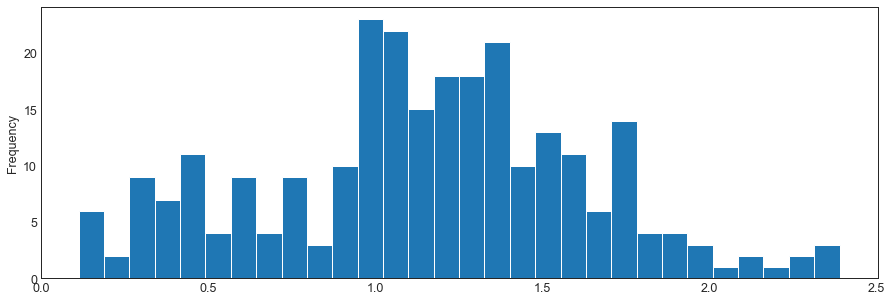

In [19]:
df_HH["HH Price Upd"].plot(kind="hist",bins = 30)
plt.show()
df_HH["Log HH Price Upd"].plot(kind="hist",bins = 30)
plt.show()

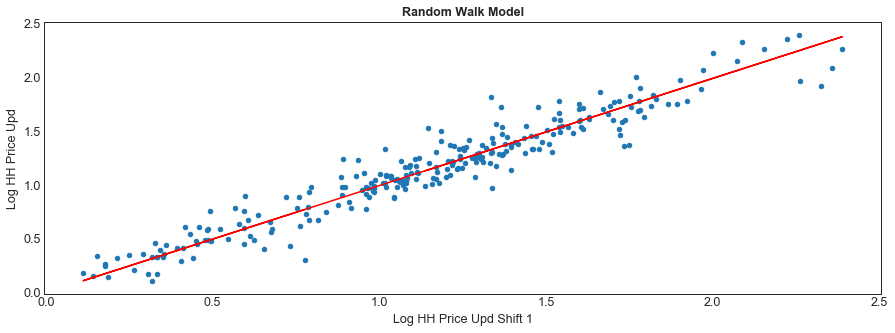

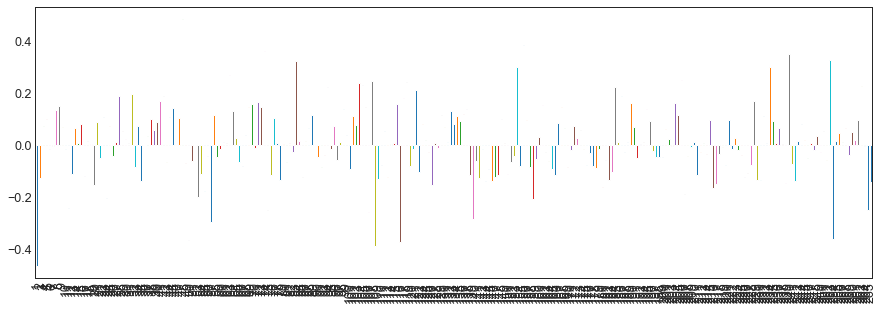

In [20]:
model_linear = sm.OLS(df_HH["Log HH Price Upd"], df_HH["Log HH Price Upd Shift 1"]).fit()
model_linear_pred = model_linear.predict()
df_HH["Log HH Price Upd Fitted"] = model_linear_pred


large = 16; med = 12.5; small = 11
params = {'axes.titlesize': med,
        'legend.fontsize': small,
        'figure.figsize': (15, 5),
        'axes.labelsize': med,
        'axes.titlesize': med,
        'xtick.labelsize': med,
        'ytick.labelsize': med,
        'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

df_HH.plot(kind="scatter",x="Log HH Price Upd Shift 1",y="Log HH Price Upd")
plt.plot(df_HH["Log HH Price Upd Shift 1"],df_HH["Log HH Price Upd Fitted"],c="r")

str_title = "Random Walk Model"
plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.savefig(FileName)

plt.show()

model_linear.resid.plot(kind="bar")

In [21]:
print(model_linear.params)
R2 = model_linear.rsquared
pp = model_linear.pvalues
model_linear.summary()

Log HH Price Upd Shift 1    0.994612
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log HH Price Upd   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.240e+04
Date:                Fri, 29 Mar 2019   Prob (F-statistic):          2.71e-257
Time:                        16:59:07   Log-Likelihood:                 155.47
No. Observations:                 265   AIC:                            -308.9
Df Residuals:                     264   BIC:                            -305.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Log HH Price Upd Shift 1     0.9946      0.007    149.675      0.000       0.982       1.008
==============================================================================
Omnibus:                        9.834   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               19.607
Skew:                           0.017   Prob(JB):                     5.53e-05
Kurtosis:                       4.332   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

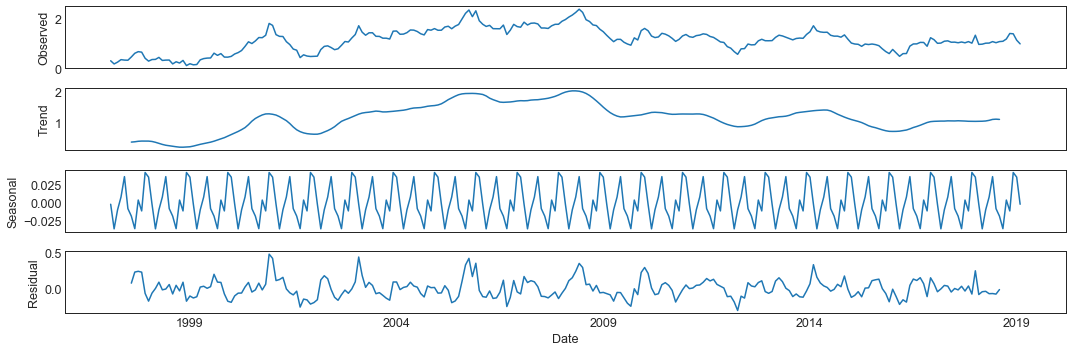

In [23]:
df_HH["Date"] = pd.to_datetime(df_HH["Date"])
df_HH = df_HH.set_index('Date')
df_HH.head()

#decomposition = seasonal_decompose(df_HH["Log HH Price Upd"], model = "multiplicative")
decomposition = seasonal_decompose(df_HH["Log HH Price Upd"], model = "additive")

decomposition.plot()

str_title = "Decomposition Model"
#plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.savefig(FileName)

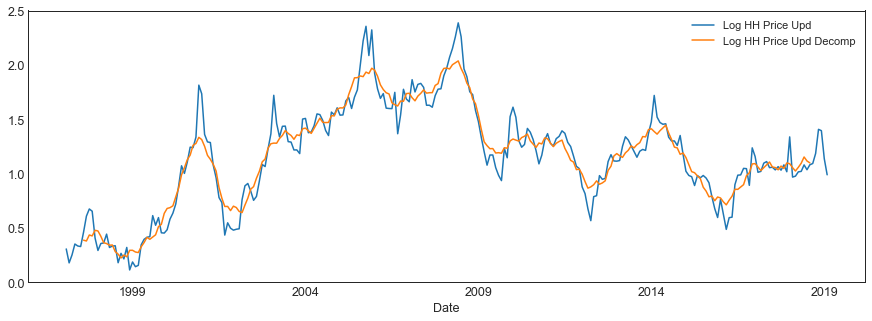

In [24]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df_HH["Log HH Price Upd Decomp"] = trend + seasonal

df_HH.plot(kind="line",y=["Log HH Price Upd","Log HH Price Upd Decomp"])

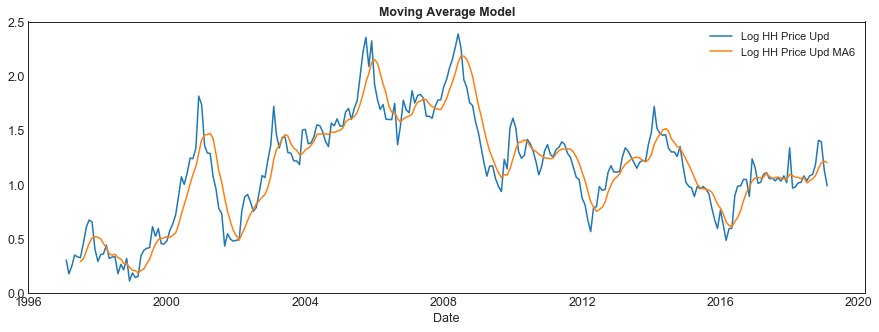

In [22]:
# For smoothing the values we can use 6 month Moving Averages

df_HH["Log HH Price Upd MA6"] = df_HH["Log HH Price Upd"].rolling(window=6).mean()
df_HH

large = 16; med = 12.5; small = 11
params = {'axes.titlesize': med,
        'legend.fontsize': small,
        'figure.figsize': (15, 5),
        'axes.labelsize': med,
        'axes.titlesize': med,
        'xtick.labelsize': med,
        'ytick.labelsize': med,
        'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

df_HH.plot(kind="line",x="Date",y=["Log HH Price Upd","Log HH Price Upd MA6"])

str_title = "Moving Average Model"
plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.savefig(FileName)


In [29]:
# Running the ARIMA Model(1,0,1)
# model_AR1MA = ARIMA(ts_diff, order=(1,0,1))
ts = residual
ts = ts.dropna()
model_AR1MA = ARIMA(ts, order=(1,0,1))
#results_ARIMA = model_AR1MA.fit(disp = -1)
results_ARIMA = model_AR1MA.fit()
results_ARIMA.fittedvalues.head()
results_ARIMA.summary()

C:\Users\Asterion\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       Log HH Price Upd   No. Observations:                  253
Model:                     ARMA(1, 1)   Log Likelihood                 208.066
Method:                       css-mle   S.D. of innovations              0.106
Date:                Fri, 29 Mar 2019   AIC                           -408.133
Time:                        17:04:35   BIC                           -393.999
Sample:                    08-01-1997   HQIC                          -402.446
                         - 08-01-2018                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0007      0.015      0.049      0.961      -0.028       0.030
ar.L1.Log HH Price Upd     0.4917      0.086      5.687      0.000       0.322       0.661
ma.L1.Log HH Price Upd     0.1294      0.094      1.373      0.171      -0.055       0.314
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0338           +0.0000j            2.0338            0.0000
MA.1           -7.7274           +0.0000j            7.7274            0.5000
-----------------------------------------------------------------------------
"""

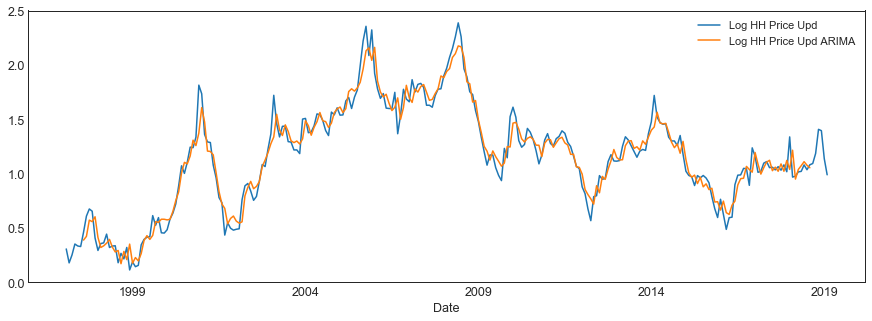

In [30]:
df_HH['Log HH Price Upd ARIMA'] = results_ARIMA.fittedvalues + trend + seasonal
df_HH.plot(kind="line", y = ["Log HH Price Upd", "Log HH Price Upd ARIMA"])

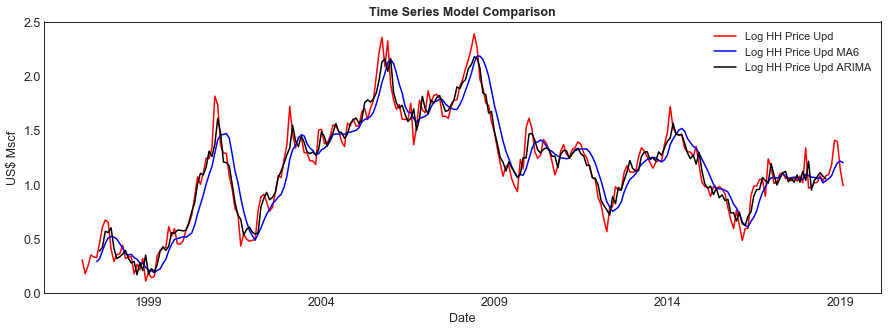

In [31]:
large = 16; med = 12.5; small = 11
params = {'axes.titlesize': med,
        'legend.fontsize': small,
        'figure.figsize': (15, 5),
        'axes.labelsize': med,
        'axes.titlesize': med,
        'xtick.labelsize': med,
        'ytick.labelsize': med,
        'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

styles = ['r-','b',"k"]
df_HH.plot(kind="line", y = ["Log HH Price Upd","Log HH Price Upd MA6","Log HH Price Upd ARIMA"],
          style=styles)

str_title = "Time Series Model Comparison"
plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.ylabel("US$ Mscf")
plt.savefig(FileName)

plt.show()